# K-Dependent Phase Transition in RWSE Encoding Quality

This notebook demonstrates a method for testing whether **Random Walk Structural Encoding (RWSE)** quality exhibits a K-dependent phase transition at **K\* = 1/δ_min** (the reciprocal of the minimum eigenvalue gap).

**What it does:**
- Generates synthetic graphs with diverse spectral properties
- Computes eigendecomposition and RWSE features at varying walk lengths K
- Measures encoding quality via node distinguishability and spectral reconstruction error
- Fits sigmoid curves to quality-vs-K curves and correlates inflection points with K\*
- Tests the hypothesis using Spearman correlation across multiple graph families

**Key finding:** K_half Spearman ρ = 0.159 (p=0.013); hypothesis NOT confirmed (requires ρ > 0.5).

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All needed packages are pre-installed on Colab. Install locally to match Colab env.
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'matplotlib==3.10.0', 'networkx==3.6.1')


[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import json
import math
import os
import random
import warnings

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

warnings.filterwarnings("ignore")

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-ace67e-the-walk-resolution-limit-a-super-resolu/main/experiment_iter4_k_dependent_pha/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded experiment: {data['metadata']['experiment']}")
print(f"Datasets: {[d['dataset'] for d in data['datasets']]}")
print(f"Total examples: {sum(len(d['examples']) for d in data['datasets'])}")

Loaded experiment: K_dependent_phase_transition
Datasets: ['ZINC-subset', 'Peptides-func', 'Peptides-struct', 'Synthetic-aliased-pairs', 'Custom-synthetic']
Total examples: 15


## Configuration

All tunable parameters for the experiment. Adjust these to trade off between computation time and result quality.

In [5]:
# ── Tunable parameters ──────────────────────────────────────────────────

# Walk lengths to evaluate
K_VALUES_EXTENDED = [2, 4, 8, 12, 16, 24, 32, 48, 64]

# Epsilon values for distinguishability threshold
EPS_VALUES = [1e-6, 1e-4, 1e-2]

# Number of custom synthetic graphs to generate
N_SYNTHETIC_GRAPHS = 50

# Number of random graph trials to find candidates
N_TRIALS = 200

# Random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

## Step 1: Core Graph Processing Functions

Eigendecomposition, RWSE computation, and quality metrics.

In [6]:
def build_adjacency(edge_index, num_nodes):
    """Build adjacency matrix from edge_index."""
    A = np.zeros((num_nodes, num_nodes), dtype=np.float64)
    src, dst = edge_index[0], edge_index[1]
    for s, d in zip(src, dst):
        A[s, d] = 1.0
    return A


def compute_spectral(A):
    """Compute eigendecomposition of A and symmetric normalized matrix S."""
    n = A.shape[0]
    degrees = A.sum(axis=1)
    degrees_safe = np.maximum(degrees, 1e-10)

    # Symmetric normalized matrix S = D^{-1/2} A D^{-1/2}
    d_inv_half = 1.0 / np.sqrt(degrees_safe)
    d_inv_half[degrees < 0.5] = 0.0
    S = (d_inv_half[:, None] * A) * d_inv_half[None, :]

    # Eigendecomposition
    eig_A, vec_A = np.linalg.eigh(A)
    eig_S, vec_S = np.linalg.eigh(S)

    # Sort by ascending eigenvalue
    idx_A = np.argsort(eig_A)
    eig_A, vec_A = eig_A[idx_A], vec_A[:, idx_A]
    idx_S = np.argsort(eig_S)
    eig_S, vec_S = eig_S[idx_S], vec_S[:, idx_S]

    # Delta min
    sorted_A = np.sort(eig_A)
    diffs_A = np.diff(sorted_A)
    delta_min_A = float(np.min(diffs_A)) if len(diffs_A) > 0 else 0.0

    sorted_S = np.sort(eig_S)
    diffs_S = np.diff(sorted_S)
    delta_min_S = float(np.min(diffs_S)) if len(diffs_S) > 0 else 0.0

    # K* = ceil(1 / delta_min)
    K_star_A = math.ceil(1.0 / delta_min_A) if delta_min_A > 1e-12 else 9999
    K_star_S = math.ceil(1.0 / delta_min_S) if delta_min_S > 1e-12 else 9999

    # Laplacian eigenvalues for heat kernel
    L = np.diag(degrees) - A
    eig_L, vec_L = np.linalg.eigh(L)
    idx_L = np.argsort(eig_L)
    eig_L, vec_L = eig_L[idx_L], vec_L[:, idx_L]

    return {
        "eig_A": eig_A, "vec_A": vec_A,
        "eig_S": eig_S, "vec_S": vec_S,
        "eig_L": eig_L, "vec_L": vec_L,
        "delta_min_A": delta_min_A, "delta_min_S": delta_min_S,
        "K_star_A": K_star_A, "K_star_S": K_star_S,
        "degrees": degrees,
    }


def compute_rwse_matrix(eig_S, vec_S, max_K):
    """Compute RWSE feature matrix [n_nodes x max_K] for k=1..max_K."""
    vec_sq = vec_S ** 2
    rwse_matrix = np.zeros((vec_S.shape[0], max_K))
    for k in range(1, max_K + 1):
        powers = eig_S ** k
        rwse_matrix[:, k - 1] = vec_sq @ powers
    return rwse_matrix


def compute_distinguishability(rwse_matrix, eps_values):
    """Compute fraction of node pairs with distance > eps."""
    n = rwse_matrix.shape[0]
    if n < 2:
        return {eps: 0.0 for eps in eps_values}, 0.0
    dists = pdist(rwse_matrix, metric="euclidean")
    result = {}
    for eps in eps_values:
        result[eps] = float(np.mean(dists > eps))
    mean_dist = float(np.mean(dists))
    return result, mean_dist


def compute_spectral_recon_error(eig_S, vec_S, rwse_matrix, alpha=1e-4):
    """Compute spectral reconstruction error using Tikhonov-regularized inversion."""
    n = vec_S.shape[0]
    max_K = rwse_matrix.shape[1]
    if max_K < 2 or n < 2:
        return float("nan")

    w_true_all = vec_S ** 2
    V = np.zeros((max_K, n))
    for k in range(max_K):
        V[k, :] = eig_S ** (k + 1)

    total_W1 = 0.0
    valid_count = 0
    node_sample = list(range(n))
    if n > 30:
        node_sample = random.sample(node_sample, 30)

    for u in node_sample:
        m = rwse_matrix[u, :]
        try:
            V_aug = np.vstack([V, np.sqrt(alpha) * np.eye(n)])
            m_aug = np.concatenate([m, np.zeros(n)])
            w_hat, _, _, _ = np.linalg.lstsq(V_aug, m_aug, rcond=None)
            w_hat = np.maximum(w_hat, 0)
            if w_hat.sum() > 1e-15:
                w_hat /= w_hat.sum()
            else:
                continue
            w_true = w_true_all[u, :]
            if w_true.sum() < 1e-15:
                continue
            sorted_idx = np.argsort(eig_S)
            cdf_true = np.cumsum(w_true[sorted_idx])
            cdf_hat = np.cumsum(w_hat[sorted_idx])
            sorted_eigs = eig_S[sorted_idx]
            if len(sorted_eigs) > 1:
                dx = np.diff(sorted_eigs)
                avg_diff = 0.5 * (np.abs(cdf_true[:-1] - cdf_hat[:-1]) +
                                  np.abs(cdf_true[1:] - cdf_hat[1:]))
                W1 = float(np.sum(avg_diff * dx))
            else:
                W1 = 0.0
            total_W1 += W1
            valid_count += 1
        except Exception:
            continue

    if valid_count == 0:
        return float("nan")
    return total_W1 / valid_count


def compute_lape_distinguishability(vec_A, d, eps=1e-6):
    """Compute LapPE-style distinguishability using top-d squared eigenvectors."""
    n = vec_A.shape[0]
    if n < 2 or d < 1:
        return 0.0
    actual_d = min(d, vec_A.shape[1])
    features = vec_A[:, :actual_d] ** 2
    dists = pdist(features, metric="euclidean")
    return float(np.mean(dists > eps))

print("Core functions defined.")

Core functions defined.


## Step 2: Generate Synthetic Graphs

Create synthetic graphs with diverse δ_min values using multiple graph families (ER, BA, SBM, regular, path, cycle).

In [7]:
def generate_synthetic_graphs(n_graphs=N_SYNTHETIC_GRAPHS, n_trials=N_TRIALS):
    """Generate synthetic graphs with diverse delta_min values."""
    target_delta_mins = np.concatenate([
        np.linspace(0.01, 0.05, max(1, n_graphs // 4)),
        np.linspace(0.05, 0.2, max(1, n_graphs // 4)),
        np.linspace(0.2, 0.5, max(1, n_graphs // 4)),
        np.linspace(0.5, 2.0, max(1, n_graphs // 4)),
    ])
    np.random.shuffle(target_delta_mins)
    target_delta_mins = target_delta_mins[:n_graphs]

    synthetic_graphs = []
    all_candidates = []

    for trial in range(n_trials * 3):
        graph_type = random.choice(["ER", "BA", "SBM", "regular", "path", "cycle", "SBM3"])
        try:
            if graph_type == "path":
                n = random.randint(4, 20)
                G = nx.path_graph(n)
            elif graph_type == "cycle":
                n = random.randint(4, 20)
                G = nx.cycle_graph(n)
            elif graph_type == "regular":
                n = random.randint(6, 30)
                d = random.randint(2, min(5, n - 1))
                if (n * d) % 2 != 0:
                    n += 1
                G = nx.random_regular_graph(d, n, seed=SEED + trial)
            elif graph_type == "ER":
                n = random.randint(5, 50)
                p = random.uniform(0.1, 0.8)
                G = nx.erdos_renyi_graph(n, p, seed=SEED + trial)
            elif graph_type == "BA":
                n = random.randint(5, 50)
                m = random.randint(1, min(5, n - 1))
                G = nx.barabasi_albert_graph(n, m, seed=SEED + trial)
            elif graph_type == "SBM3":
                sizes = [random.randint(3, 10) for _ in range(3)]
                p_in = random.uniform(0.3, 0.9)
                p_out = random.uniform(0.01, 0.15)
                probs = [[p_in if i == j else p_out for j in range(3)] for i in range(3)]
                G = nx.stochastic_block_model(sizes, probs, seed=SEED + trial)
            else:  # SBM
                n = random.randint(6, 40)
                n1 = random.randint(3, n - 3)
                n2 = n - n1
                p_in = random.uniform(0.3, 0.9)
                p_out = random.uniform(0.01, 0.3)
                G = nx.stochastic_block_model(
                    [n1, n2], [[p_in, p_out], [p_out, p_in]], seed=SEED + trial)

            if not nx.is_connected(G):
                continue
            A = nx.to_numpy_array(G)
            degrees = A.sum(axis=1)
            if np.any(degrees < 0.5):
                continue
            d_inv_half = 1.0 / np.sqrt(degrees)
            S_mat = (d_inv_half[:, None] * A) * d_inv_half[None, :]
            eigs_S = np.linalg.eigvalsh(S_mat)
            dm_S = float(np.min(np.diff(np.sort(eigs_S))))
            eigs_A = np.linalg.eigvalsh(A)
            dm_A = float(np.min(np.diff(np.sort(eigs_A))))
            all_candidates.append({
                "G": G, "A": A, "n_nodes": len(G),
                "graph_type": graph_type,
                "delta_min_S": dm_S, "delta_min_A": dm_A,
            })
        except Exception:
            continue

    print(f"Generated {len(all_candidates)} candidate synthetic graphs")

    # Match each target to closest candidate
    used = set()
    for target_dm in sorted(target_delta_mins):
        best_idx = None
        best_error = float("inf")
        for i, c in enumerate(all_candidates):
            if i in used:
                continue
            error = abs(c["delta_min_S"] - target_dm)
            if error < best_error:
                best_error = error
                best_idx = i
        if best_idx is not None:
            used.add(best_idx)
            cand = all_candidates[best_idx]
            cand["target_delta_min"] = float(target_dm)
            spec = compute_spectral(cand["A"])
            cand.update(spec)
            edges = list(cand["G"].edges())
            src = [e[0] for e in edges] + [e[1] for e in edges]
            dst = [e[1] for e in edges] + [e[0] for e in edges]
            cand["edge_index"] = [src, dst]
            synthetic_graphs.append(cand)

    print(f"Selected {len(synthetic_graphs)}/{n_graphs} synthetic graphs")
    if synthetic_graphs:
        dm_vals = [g["delta_min_S"] for g in synthetic_graphs]
        print(f"  delta_min_S range: [{min(dm_vals):.6f}, {max(dm_vals):.4f}]")
    return synthetic_graphs

synthetic_graphs = generate_synthetic_graphs()

Generated 545 candidate synthetic graphs
Selected 48/50 synthetic graphs
  delta_min_S range: [0.010047, 0.5000]


## Step 3: Process Synthetic Graphs

Compute RWSE quality metrics at each walk length K for synthetic graphs, then parse loaded pre-computed results from the dataset.

In [8]:
def process_synthetic_graph(syn, graph_idx):
    """Process a custom synthetic graph (already has eigendecomposition)."""
    eig_S, vec_S = syn["eig_S"], syn["vec_S"]
    eig_A, vec_A = syn["eig_A"], syn["vec_A"]
    eig_L, vec_L = syn["eig_L"], syn["vec_L"]
    n_nodes = syn["n_nodes"]

    quality_vs_K = {}
    for max_K in K_VALUES_EXTENDED:
        mat = compute_rwse_matrix(eig_S, vec_S, max_K)
        dist_fracs, mean_dist = compute_distinguishability(mat, EPS_VALUES)
        recon_err = float("nan")
        if max_K >= 4:
            recon_err = compute_spectral_recon_error(eig_S, vec_S, mat)
        quality_vs_K[max_K] = {
            "distinguish": dist_fracs,
            "mean_dist": mean_dist,
            "recon_error": recon_err,
        }

    lape_dist = compute_lape_distinguishability(vec_A, max(K_VALUES_EXTENDED))

    # Walk A features
    quality_walk_A = {}
    for max_K in K_VALUES_EXTENDED:
        vec_sq_A = vec_A ** 2
        rho = max(abs(eig_A.max()), abs(eig_A.min()))
        if rho < 1e-12:
            rho = 1.0
        norm_eigs_A = eig_A / rho
        mat_A = np.zeros((n_nodes, max_K))
        for k in range(1, max_K + 1):
            powers = norm_eigs_A ** k
            mat_A[:, k - 1] = vec_sq_A @ powers
        dist_fracs_A, mean_dist_A = compute_distinguishability(mat_A, EPS_VALUES)
        quality_walk_A[max_K] = {
            "distinguish": dist_fracs_A,
            "mean_dist": mean_dist_A,
        }

    # Heat kernel with adaptive t scaling
    spectral_gap = eig_L[1] if len(eig_L) > 1 and eig_L[1] > 0.01 else 0.1
    t_scale = 1.0 / spectral_gap
    quality_hk = {}
    vec_sq_L = vec_L ** 2
    for max_K in K_VALUES_EXTENDED:
        mat_hk = np.zeros((n_nodes, max_K))
        for k_idx in range(max_K):
            t = (k_idx + 1) * t_scale / max_K
            weights = np.exp(-t * eig_L)
            mat_hk[:, k_idx] = vec_sq_L @ weights
        dist_fracs_hk, mean_dist_hk = compute_distinguishability(mat_hk, EPS_VALUES)
        quality_hk[max_K] = {
            "distinguish": dist_fracs_hk,
            "mean_dist": mean_dist_hk,
        }

    return {
        "graph_idx": graph_idx,
        "n_nodes": n_nodes,
        "delta_min_A": syn["delta_min_A"],
        "delta_min_S": syn["delta_min_S"],
        "K_star_A": syn["K_star_A"],
        "K_star_S": syn["K_star_S"],
        "quality_vs_K": quality_vs_K,
        "quality_walk_A": quality_walk_A,
        "quality_hk": quality_hk,
        "lape_distinguish": lape_dist,
        "has_full_spectral": True,
        "graph_type": syn.get("graph_type", "unknown"),
        "eig_S": eig_S,
    }


# Process synthetic graphs
syn_results = []
for i, syn in enumerate(synthetic_graphs):
    try:
        result = process_synthetic_graph(syn, i)
        syn_results.append(result)
    except Exception as e:
        print(f"Failed on synthetic graph {i}: {e}")
        syn_results.append(None)

print(f"Processed {sum(1 for r in syn_results if r is not None)} synthetic graphs")

# Parse pre-computed results from loaded data
parsed_results = []
for ds in data["datasets"]:
    for ex in ds["examples"]:
        inp = json.loads(ex["input"])
        out = json.loads(ex["output"])
        # Reconstruct intermediate result format
        quality_vs_K = {}
        for K_str, q_data in out.get("quality_vs_K", {}).items():
            K_int = int(K_str)
            quality_vs_K[K_int] = {
                "distinguish": {1e-6: q_data.get("distinguish_1e-6", 0.0)},
                "mean_dist": q_data.get("mean_dist", 0.0),
            }
        parsed_results.append({
            "graph_idx": inp.get("graph_idx", -1),
            "n_nodes": inp.get("n_nodes", 0),
            "delta_min_A": inp.get("delta_min_A", 0),
            "delta_min_S": inp.get("delta_min_S", inp.get("delta_min_A", 0)),
            "K_star_A": inp.get("K_star_A", 9999),
            "K_star_S": inp.get("K_star_S", inp.get("K_star_A", 9999)),
            "quality_vs_K": quality_vs_K,
            "has_full_spectral": False,
            "dataset": ds["dataset"],
        })

print(f"Parsed {len(parsed_results)} pre-computed graph results from data")

Processed 48 synthetic graphs
Parsed 15 pre-computed graph results from data


## Step 4: Phase Transition Analysis

Fit sigmoid curves to quality-vs-K data, compute K_half thresholds, and test Spearman correlation between K* and observed inflection points.

In [9]:
def sigmoid(K, L, rate, K_mid, baseline):
    """Sigmoid function for quality vs K."""
    return L / (1.0 + np.exp(-rate * (K - K_mid))) + baseline


def fit_sigmoid(K_values, quality_values):
    """Fit sigmoid to quality-vs-K curve, return inflection point and fit quality."""
    K_arr = np.array(K_values, dtype=float)
    q_arr = np.array(quality_values, dtype=float)
    q_range = q_arr.max() - q_arr.min()
    if q_range < 0.01:
        return {"K_inflect": float("nan"), "R2": 0.0, "success": False, "params": None}
    diffs = np.diff(q_arr)
    if np.all(diffs <= 0):
        return {"K_inflect": float("nan"), "R2": 0.0, "success": False, "params": None}
    try:
        best_result = None
        best_R2 = -999
        for K_mid_init in [float(np.median(K_arr)), K_arr[1], K_arr[-2]]:
            try:
                p0 = [q_range, 0.3, K_mid_init, float(q_arr.min())]
                bounds = ([0, 0.001, 0.5, -2], [2, 10, 200, 2])
                popt, pcov = curve_fit(sigmoid, K_arr, q_arr, p0=p0,
                                       bounds=bounds, maxfev=2000)
                K_inflect = popt[2]
                y_pred = sigmoid(K_arr, *popt)
                ss_res = np.sum((q_arr - y_pred) ** 2)
                ss_tot = np.sum((q_arr - q_arr.mean()) ** 2)
                R2 = 1 - ss_res / max(ss_tot, 1e-15)
                if R2 > best_R2:
                    best_R2 = R2
                    best_result = (K_inflect, R2, popt)
            except (RuntimeError, ValueError):
                continue
        if best_result is None:
            return {"K_inflect": float("nan"), "R2": 0.0, "success": False, "params": None}
        K_inflect, R2, popt = best_result
        success = 0.5 < K_inflect < 200 and R2 > 0.3
        return {"K_inflect": float(K_inflect), "R2": float(R2),
                "success": success, "params": [float(p) for p in popt]}
    except Exception:
        return {"K_inflect": float("nan"), "R2": 0.0, "success": False, "params": None}


def compute_K_half(K_values, quality_values):
    """Fallback: K at which quality first exceeds 50% of its range."""
    q_arr = np.array(quality_values)
    q_min, q_max = q_arr.min(), q_arr.max()
    threshold = (q_min + q_max) / 2
    for K, q in zip(K_values, quality_values):
        if q >= threshold:
            return float(K)
    return float(K_values[-1])


def _extract_quality_curve(r, K_vals, quality_key, eps):
    """Extract (K_list, quality_list) from a result dict."""
    q_vals = []
    K_list = []
    for K in K_vals:
        K_key = int(K)
        q_data = r.get(quality_key, {}).get(K_key, {})
        dist = q_data.get("distinguish", {})
        if isinstance(dist, dict):
            if eps in dist:
                q = dist[eps]
            else:
                closest = min(dist.keys(), key=lambda e: abs(e - eps), default=None)
                q = dist.get(closest, 0.0) if closest is not None else 0.0
        else:
            q = 0.0
        q_vals.append(q)
        K_list.append(K)
    return K_list, q_vals


# Combine all results
all_results = parsed_results + [r for r in syn_results if r is not None]
full_spectral_results = [r for r in all_results if r.get("has_full_spectral", False)]

print(f"Total results: {len(all_results)}")
print(f"Full spectral results: {len(full_spectral_results)}")

# Run analysis: sigmoid fitting and K_half correlation on full spectral results
K_inflect_list = []
K_star_list = []
K_half_list = []
K_star_half_list = []
sigmoid_results = []

for r in full_spectral_results:
    K_star = r.get("K_star_S", r.get("K_star_A", 9999))
    if K_star > 200 or K_star < 1:
        continue
    K_list, q_vals = _extract_quality_curve(r, K_VALUES_EXTENDED, "quality_vs_K", 1e-6)
    fit = fit_sigmoid(K_list, q_vals)
    K_half = compute_K_half(K_list, q_vals)

    sigmoid_results.append({
        "graph_idx": r.get("graph_idx", -1),
        "K_star": K_star,
        "K_inflect": fit["K_inflect"],
        "K_half": K_half,
        "R2": fit["R2"],
        "success": fit["success"],
    })

    if fit["success"]:
        K_inflect_list.append(fit["K_inflect"])
        K_star_list.append(K_star)

    if not math.isnan(K_half):
        K_half_list.append(K_half)
        K_star_half_list.append(K_star)

# Spearman correlations
if len(K_inflect_list) >= 3:
    rho_sig, p_sig = spearmanr(K_star_list, K_inflect_list)
    print(f"\nSigmoid Spearman: rho={rho_sig:.4f}, p={p_sig:.4f}, n={len(K_inflect_list)}")
else:
    rho_sig, p_sig = float("nan"), float("nan")
    print(f"\nToo few sigmoid fits ({len(K_inflect_list)})")

if len(K_half_list) >= 3:
    rho_kh, p_kh = spearmanr(K_star_half_list, K_half_list)
    print(f"K_half Spearman: rho={rho_kh:.4f}, p={p_kh:.4f}, n={len(K_half_list)}")
else:
    rho_kh, p_kh = float("nan"), float("nan")
    print(f"Too few K_half results ({len(K_half_list)})")

print(f"\nSigmoid fits: {sum(1 for s in sigmoid_results if s['success'])}/{len(sigmoid_results)}")

Total results: 63
Full spectral results: 48



Sigmoid Spearman: rho=0.0182, p=0.9137, n=38
K_half Spearman: rho=0.2377, p=0.1037, n=48

Sigmoid fits: 38/48


## Step 5: Results Summary & Visualization

Display key results from both the pre-computed full experiment and the live demo analysis, then plot quintile curves and quality-vs-K relationships.

FULL EXPERIMENT RESULTS (pre-computed on all datasets)
  Hypothesis confirmed: False
  Sigmoid Spearman rho:   -0.0190  (p=0.7741, n=231)
  K_half Spearman rho:    0.1588  (p=0.0128, n=245)
  Mean dist K_half rho:   -0.2506  (p=0.000073, n=245)
  Sharpness ratio:        1.0356
  Fraction sharp:         0.0000

  Per-dataset K_half Spearman rho:
    ZINC-subset                   : rho=0.0, n=169
    Peptides-func                 : rho=nan, n=3
    Peptides-struct               : rho=nan, n=3
    Synthetic-aliased-pairs       : rho=0.5333904566301705, n=20
    Custom-synthetic              : rho=0.10425073003644547, n=50

  Alternative delta_min definitions:
    effective_delta_min      : rho=-0.0951, n=233
    mean_spacing             : rho=-0.1275, n=968
    spectral_gap             : rho=-0.0568, n=970
    vandermonde_cond         : rho=-0.1134, n=233

LIVE DEMO RESULTS (synthetic graphs + loaded examples)
  Graphs processed:       63
  Full spectral:          48
  K_half Spearman rho

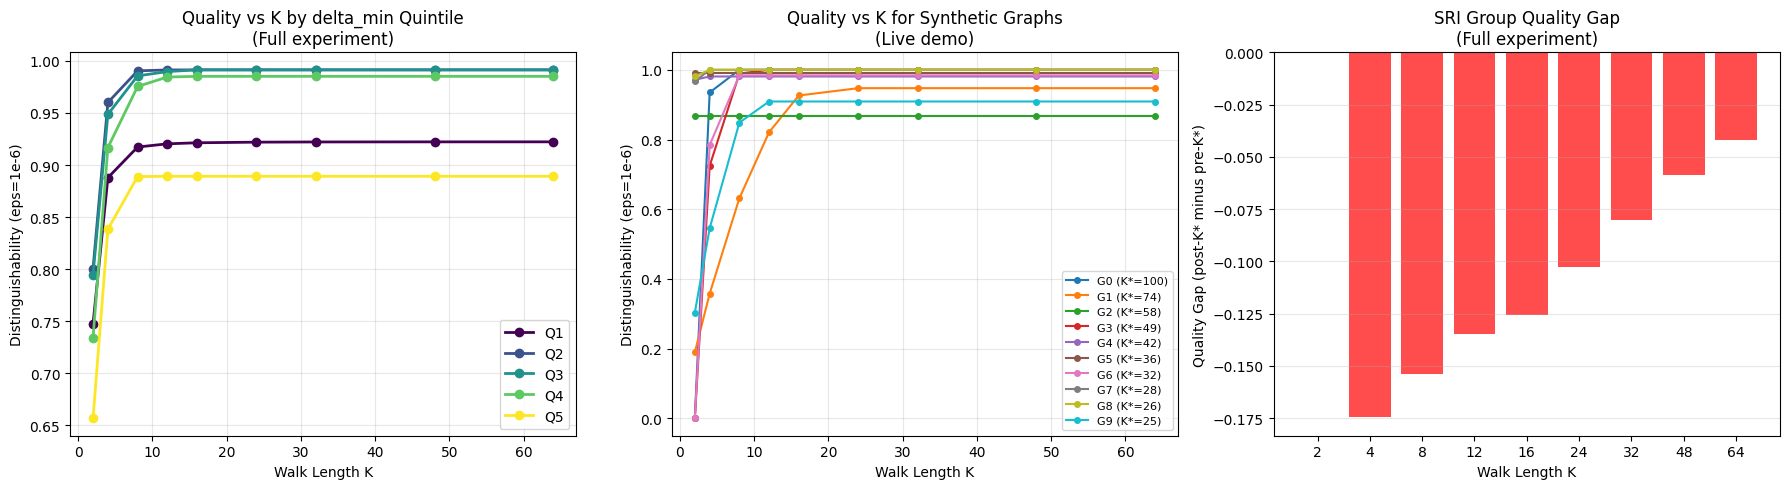


Visualization saved to results_visualization.png


In [10]:
# ── Summary Table ─────────────────────────────────────────────────────
meta = data["metadata"]
global_res = meta["global_results"]
corr = global_res["spearman_rho_Kinflect_vs_Kstar"]

print("=" * 70)
print("FULL EXPERIMENT RESULTS (pre-computed on all datasets)")
print("=" * 70)
print(f"  Hypothesis confirmed: {meta['confirms_hypothesis']}")
print(f"  Sigmoid Spearman rho:   {corr['sigmoid']['rho']:.4f}  (p={corr['sigmoid']['p_value']:.4f}, n={corr['sigmoid']['n']})")
print(f"  K_half Spearman rho:    {corr['K_half_fallback']['rho']:.4f}  (p={corr['K_half_fallback']['p_value']:.4f}, n={corr['K_half_fallback']['n']})")
print(f"  Mean dist K_half rho:   {corr['mean_dist_K_half']['rho']:.4f}  (p={corr['mean_dist_K_half']['p_value']:.6f}, n={corr['mean_dist_K_half']['n']})")
print(f"  Sharpness ratio:        {global_res['mean_sharpness_ratio']:.4f}")
print(f"  Fraction sharp:         {global_res['fraction_sharp_transitions']:.4f}")

print("\n  Per-dataset K_half Spearman rho:")
for ds_name, ds_info in meta.get("per_dataset_results", {}).items():
    rho_val = ds_info.get("analysis", {}).get("spearman_khalf", {}).get("rho", "N/A")
    n_val = ds_info.get("analysis", {}).get("spearman_khalf", {}).get("n", 0)
    print(f"    {ds_name:30s}: rho={rho_val}, n={n_val}")

print("\n  Alternative delta_min definitions:")
for dm_type, dm_res in global_res.get("alternative_delta_min_results", {}).items():
    print(f"    {dm_type:25s}: rho={dm_res['spearman_rho']:.4f}, n={dm_res['n_graphs']}")

print("\n" + "=" * 70)
print("LIVE DEMO RESULTS (synthetic graphs + loaded examples)")
print("=" * 70)
print(f"  Graphs processed:       {len(all_results)}")
print(f"  Full spectral:          {len(full_spectral_results)}")
if not math.isnan(rho_kh):
    print(f"  K_half Spearman rho:    {rho_kh:.4f}  (n={len(K_half_list)})")
if not math.isnan(rho_sig):
    print(f"  Sigmoid Spearman rho:   {rho_sig:.4f}  (n={len(K_inflect_list)})")

# ── Visualization ─────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Quintile curves from pre-computed data
ax1 = axes[0]
quintile_curves = global_res.get("quintile_curves", {})
colors = plt.cm.viridis(np.linspace(0, 1, 5))
for i, (qname, qdata) in enumerate(sorted(quintile_curves.items())):
    K_vals_plot = sorted([int(k) for k in qdata.keys()])
    q_vals_plot = [qdata[str(k)] if isinstance(list(qdata.keys())[0], str)
                   else qdata[k] for k in K_vals_plot]
    ax1.plot(K_vals_plot, q_vals_plot, 'o-', color=colors[i], label=qname, linewidth=2)
ax1.set_xlabel("Walk Length K")
ax1.set_ylabel("Distinguishability (eps=1e-6)")
ax1.set_title("Quality vs K by delta_min Quintile\n(Full experiment)")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Quality vs K for demo synthetic graphs
ax2 = axes[1]
valid_syn = [r for r in syn_results if r is not None]
for idx, r in enumerate(valid_syn[:10]):  # plot up to 10
    K_list, q_vals = _extract_quality_curve(r, K_VALUES_EXTENDED, "quality_vs_K", 1e-6)
    label = f"G{r['graph_idx']} (K*={r['K_star_S']})"
    ax2.plot(K_list, q_vals, 'o-', label=label, linewidth=1.5, markersize=4)
ax2.set_xlabel("Walk Length K")
ax2.set_ylabel("Distinguishability (eps=1e-6)")
ax2.set_title("Quality vs K for Synthetic Graphs\n(Live demo)")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: SRI gap analysis from pre-computed data
ax3 = axes[2]
sri_gaps = global_res.get("SRI_group_quality_gaps", {})
K_vals_sri = sorted([int(k) for k in sri_gaps.keys()])
gaps = []
for K in K_vals_sri:
    g = sri_gaps[str(K)] if str(K) in sri_gaps else sri_gaps.get(K, {})
    gap_val = g.get("gap", float("nan"))
    gaps.append(gap_val if not (isinstance(gap_val, float) and math.isnan(gap_val)) else 0)
bar_colors = ['green' if g > 0 else 'red' for g in gaps]
ax3.bar([str(k) for k in K_vals_sri], gaps, color=bar_colors, alpha=0.7)
ax3.axhline(y=0, color='black', linewidth=0.5)
ax3.set_xlabel("Walk Length K")
ax3.set_ylabel("Quality Gap (post-K* minus pre-K*)")
ax3.set_title("SRI Group Quality Gap\n(Full experiment)")
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("results_visualization.png", dpi=100, bbox_inches="tight")
plt.show()
print("\nVisualization saved to results_visualization.png")